In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow_addons.losses import TripletSemiHardLoss
from scipy.spatial.distance import cdist

In [5]:
# Path to your SavedModel directory
SAVED_MODEL_PATH = "/N/u/nothamil/BigRed200/triplet/627/DenseNet201/model"

# Load the model
model = tf.keras.models.load_model(
    SAVED_MODEL_PATH,
    custom_objects={"Addons>TripletSemiHardLoss": TripletSemiHardLoss},
)

In [6]:
# Function to preprocess an image
def preprocess_image(image_path, target_size):
    """Loads and preprocesses an image for the model."""
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1] if needed
    return img_array

# Path to the image you want to predict
IMAGE_PATH = "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation/Emphysema/Emphysema_0020.png"

# Preprocess the image (adjust target size to your model's input size)
input_image = preprocess_image(IMAGE_PATH, target_size=(224, 224))

# Make predictions
predictions = model.predict(input_image)

# Display predictions
print("Predictions:", predictions)

1/1 [==============================] - 5s 5s/step
Predictions: [[-0.11928996  0.00629503 -0.05618112  0.01309535 -0.26957828 -0.03080774
  -0.0067291   0.01191708  0.13458285  0.10892197 -0.01657924  0.08863389
  -0.04556112 -0.10072824 -0.01810488 -0.00450871  0.05142312 -0.01538756
  -0.04522187  0.25591013  0.07690565  0.146203   -0.01302459  0.04052494
  -0.04745491  0.02479416  0.02879305 -0.05211193 -0.12280759  0.06249304
  -0.00988681  0.09448065  0.054357   -0.06083065 -0.03907994 -0.03119974
   0.1596025  -0.13328631  0.05454068  0.01893424  0.0891656   0.21403933
   0.11306471  0.00710138 -0.1174159  -0.06350514  0.013781    0.09424566
  -0.07426684 -0.01021309 -0.20933484 -0.14239037  0.08429372  0.09646035
   0.02730549  0.0427236   0.0120704  -0.08786399  0.02236077 -0.0039324
   0.05600854  0.06253382  0.05905662  0.0129073  -0.05567377  0.06763292
  -0.07326826  0.05546064  0.14781746  0.00731404  0.0168793  -0.0615776
  -0.1130292   0.19716002 -0.06172574 -0.12771435  

In [16]:
# Paths to the images you want to process
image_paths = [
    "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation/Emphysema/Emphysema_0020.png",
    "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation/Emphysema/Emphysema_0022.png",
    "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation/Fibrosis/Fibrosis_0019.png",
    "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation/Fibrosis/Fibrosis_0197.png",
    "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation/PleuralThickening/Pleural_Thickening_0001.png",
    "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation/PleuralThickening/Pleural_Thickening_0118.png"

]

# Preprocess all images and collect their embeddings
embeddings = []
target_size = (224, 224)  # Adjust based on your model's input size
for image_path in image_paths:
    input_image = preprocess_image(image_path, target_size=target_size)
    embedding = model.predict(input_image)  # Generate embeddings
    embeddings.append(embedding.flatten())  # Flatten to 1D

# Convert embeddings to a NumPy array
embeddings = np.array(embeddings)

# Calculate pairwise Euclidean distances
distances = cdist(embeddings, embeddings, metric="euclidean")

# Print the distance matrix
print("Pairwise Euclidean Distances:")
print(distances)

1/1 [==============================] - 0s 234ms/step
Pairwise Euclidean Distances:
[[0.         0.         0.00025705 0.         0.00013817 0.        ]
 [0.         0.         0.00025705 0.         0.00013817 0.        ]
 [0.00025705 0.00025705 0.         0.00025705 0.00032125 0.00025705]
 [0.         0.         0.00025705 0.         0.00013817 0.        ]
 [0.00013817 0.00013817 0.00032125 0.00013817 0.         0.00013817]
 [0.         0.         0.00025705 0.         0.00013817 0.        ]]


In [17]:
import numpy as np
from scipy.spatial.distance import cdist

def calculate_map_scores(embeddings, labels, k=5):
    """
    Calculate mAP@1 and mAP@k scores for image embeddings.
    
    Args:
        embeddings (np.ndarray): Embeddings of shape (num_images, embedding_dim).
        labels (list): Ground-truth labels for each image.
        k (int): The value for mAP@k (default is 5).
    
    Returns:
        float: mAP@1 score.
        float: mAP@k score.
    """
    # Compute pairwise distances between embeddings
    distances = cdist(embeddings, embeddings, metric="euclidean")
    
    # Initialize variables for scores
    map1_scores = []
    mapk_scores = []
    
    num_images = len(labels)
    
    for i in range(num_images):
        # Exclude the current image from rankings
        indices = np.argsort(distances[i])  # Sorted indices of neighbors
        indices = indices[indices != i]  # Remove self-comparison
        
        # Get the sorted labels of the neighbors
        neighbor_labels = [labels[idx] for idx in indices]
        
        # mAP@1: Check if the nearest neighbor has the same label
        map1 = 1 if neighbor_labels[0] == labels[i] else 0
        map1_scores.append(map1)
        
        # mAP@k: Check the top-k neighbors
        relevant_neighbors = neighbor_labels[:k]
        correct_count = sum(1 for lbl in relevant_neighbors if lbl == labels[i])
        mapk_scores.append(correct_count / k)
    
    # Compute the mean scores
    map1_score = np.mean(map1_scores)
    mapk_score = np.mean(mapk_scores)
    
    return map1_score, mapk_score

# Example Usage:
# Assume `embeddings` is an array of shape (num_images, embedding_dim)
# and `labels` is a list of ground-truth labels for each image.

# Sample embeddings (3 images with 128-dimensional embeddings)
#embeddings = np.random.rand(3, 128)

# Sample labels
labels = ["emphysema", "emphysema", "fibrosis", "fibrosis", "pleuralthickening", "pleuralthickening"]

# Calculate mAP@1 and mAP@5
map1, map5 = calculate_map_scores(embeddings, labels, k=5)

print(f"mAP@1: {map1}")
print(f"mAP@5: {map5}")

mAP@1: 0.3333333333333333
mAP@5: 0.19999999999999998


In [18]:
import numpy as np
from scipy.spatial.distance import cdist

def calculate_and_print_rankings(embeddings, labels, k=5):
    """
    Calculate mAP@1, mAP@k scores and print rankings for each image.
    
    Args:
        embeddings (np.ndarray): Embeddings of shape (num_images, embedding_dim).
        labels (list): Ground-truth labels for each image.
        k (int): The value for mAP@k (default is 5).
    
    Returns:
        float: mAP@1 score.
        float: mAP@k score.
    """
    # Compute pairwise distances between embeddings
    distances = cdist(embeddings, embeddings, metric="euclidean")
    
    # Initialize variables for scores
    map1_scores = []
    mapk_scores = []
    
    num_images = len(labels)
    
    for i in range(num_images):
        # Exclude the current image from rankings
        indices = np.argsort(distances[i])  # Sorted indices of neighbors
        indices = indices[indices != i]  # Remove self-comparison
        
        # Get the sorted labels and distances of the neighbors
        neighbor_labels = [labels[idx] for idx in indices]
        neighbor_distances = [distances[i, idx] for idx in indices]
        
        # Print rankings for the current image
        print(f"Image {i} (Label: {labels[i]}):")
        for rank, (neighbor_idx, neighbor_label, neighbor_distance) in enumerate(zip(indices, neighbor_labels, neighbor_distances), start=1):
            print(f"  Rank {rank}: Image {neighbor_idx} (Label: {neighbor_label}), Distance: {neighbor_distance:.4f}")
            if rank >= k:  # Only print up to k rankings if desired
                break
        
        # mAP@1: Check if the nearest neighbor has the same label
        map1 = 1 if neighbor_labels[0] == labels[i] else 0
        map1_scores.append(map1)
        
        # mAP@k: Check the top-k neighbors
        relevant_neighbors = neighbor_labels[:k]
        correct_count = sum(1 for lbl in relevant_neighbors if lbl == labels[i])
        mapk_scores.append(correct_count / k)
    
    # Compute the mean scores
    map1_score = np.mean(map1_scores)
    mapk_score = np.mean(mapk_scores)
    
    return map1_score, mapk_score

# Example Usage:
# Sample labels
labels = ["emphysema", "emphysema", "fibrosis", "fibrosis", "pleuralthickening", "pleuralthickening"]

# Calculate mAP@1 and mAP@5
map1, map5 = calculate_and_print_rankings(embeddings, labels, k=5)

print(f"mAP@1: {map1}")
print(f"mAP@5: {map5}")

Image 0 (Label: emphysema):
  Rank 1: Image 1 (Label: emphysema), Distance: 0.0000
  Rank 2: Image 3 (Label: fibrosis), Distance: 0.0000
  Rank 3: Image 5 (Label: pleuralthickening), Distance: 0.0000
  Rank 4: Image 4 (Label: pleuralthickening), Distance: 0.0001
  Rank 5: Image 2 (Label: fibrosis), Distance: 0.0003
Image 1 (Label: emphysema):
  Rank 1: Image 0 (Label: emphysema), Distance: 0.0000
  Rank 2: Image 3 (Label: fibrosis), Distance: 0.0000
  Rank 3: Image 5 (Label: pleuralthickening), Distance: 0.0000
  Rank 4: Image 4 (Label: pleuralthickening), Distance: 0.0001
  Rank 5: Image 2 (Label: fibrosis), Distance: 0.0003
Image 2 (Label: fibrosis):
  Rank 1: Image 0 (Label: emphysema), Distance: 0.0003
  Rank 2: Image 1 (Label: emphysema), Distance: 0.0003
  Rank 3: Image 3 (Label: fibrosis), Distance: 0.0003
  Rank 4: Image 5 (Label: pleuralthickening), Distance: 0.0003
  Rank 5: Image 4 (Label: pleuralthickening), Distance: 0.0003
Image 3 (Label: fibrosis):
  Rank 1: Image 0 (Lab

In [19]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Assume `train_embeddings` is a dictionary with:
# - keys: class labels
# - values: lists of training embeddings for each class
# Example: {0: [embedding1, embedding2, ...], 1: [embedding3, ...]}

# Compute centroids for each class
def compute_centroids(train_embeddings):
    centroids = {}
    for class_label, embeddings in train_embeddings.items():
        centroids[class_label] = np.mean(embeddings, axis=0)
    return centroids

# Predict the class of a query embedding based on nearest centroid
def predict_with_centroids(query_embedding, centroids):
    # Convert centroids to matrix for efficient distance calculation
    centroid_matrix = np.array(list(centroids.values()))
    class_labels = list(centroids.keys())
    
    # Compute Euclidean distances to all centroids
    distances = euclidean_distances(query_embedding.reshape(1, -1), centroid_matrix)
    
    # Find the nearest centroid
    nearest_centroid_idx = np.argmin(distances)
    return class_labels[nearest_centroid_idx]

# Example usage:

# Example training embeddings
train_embeddings = {
    0: [np.random.rand(128) for _ in range(10)],  # Class 0 embeddings
    1: [np.random.rand(128) for _ in range(15)],  # Class 1 embeddings
}

# Compute centroids
centroids = compute_centroids(train_embeddings)

# Example query embedding
query_embedding = np.random.rand(128)

# Predict the class
predicted_class = predict_with_centroids(query_embedding, centroids)
print(f"Predicted Class: {predicted_class}")

# Evaluate on a test set
def evaluate(test_embeddings, test_labels, centroids):
    correct = 0
    total = len(test_labels)
    for embedding, true_label in zip(test_embeddings, test_labels):
        predicted_label = predict_with_centroids(embedding, centroids)
        if predicted_label == true_label:
            correct += 1
    accuracy = correct / total
    return accuracy

# Example test set
test_embeddings = [np.random.rand(128) for _ in range(20)]
test_labels = [np.random.choice([0, 1]) for _ in range(20)]

# Evaluate
accuracy = evaluate(test_embeddings, test_labels, centroids)
print(f"Accuracy: {accuracy:.2f}")

Predicted Class: 1
Accuracy: 0.50


In [ ]:
import os
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar
from scipy.spatial.distance import cdist

# Define a function to recursively load all image paths from each class subdirectory
def load_image_paths(base_dir):
    image_paths = []
    class_labels = []
    
    # Iterate through each class subdirectory in the base directory
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        
        # Only proceed if it's a directory
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith((".png", ".jpg", ".jpeg")):  # Add other image extensions if needed
                    image_paths.append(os.path.join(class_path, file))
                    class_labels.append(class_name)  # Class label is the directory name
    
    return image_paths, class_labels

# Base directory containing the training dataset
train_dir = "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation"  # Modify to your actual train directory path

# Load all image paths and their corresponding class labels
image_paths, class_labels = load_image_paths(train_dir)

# Preprocess images and collect their embeddings
train_embeddings = {}  # Dictionary to store embeddings by class
target_size = (224, 224)  # Adjust based on your model's input size

# Use tqdm to track progress
for image_path, class_label in tqdm(zip(image_paths, class_labels), total=len(image_paths), desc="Processing Images"):
    # Preprocess the image
    input_image = preprocess_image(image_path, target_size=target_size)
    
    # Generate embedding
    embedding = model.predict(input_image)
    
    # Flatten the embedding to 1D
    embedding = embedding.flatten()
    
    # Add the embedding to the dictionary
    if class_label not in train_embeddings:
        train_embeddings[class_label] = []
    train_embeddings[class_label].append(embedding)

# Convert lists of embeddings to NumPy arrays for each class
for class_label in train_embeddings:
    train_embeddings[class_label] = np.array(train_embeddings[class_label])

# Example: Print number of embeddings for each class
for class_label, embeddings in train_embeddings.items():
    print(f"Class {class_label}: {len(embeddings)} embeddings")

# Save the embeddings for later use (optional)
#np.savez("train_embeddings.npz", **train_embeddings)

In [25]:
import numpy as np

# Assuming train_embeddings is already populated from previous steps

# Dictionary to store centroids for each class
class_centroids = {}

# Compute centroid for each class
for class_label, embeddings in train_embeddings.items():
    centroid = np.mean(embeddings, axis=0)  # Compute the mean of embeddings for each class
    class_centroids[class_label] = centroid

# Example: Print centroids
for class_label, centroid in class_centroids.items():
    print(f"Centroid for class {class_label}: {centroid[:5]}...")  # Print first 5 values of the centroid

Centroid for class Pneumonia: [-0.11929025  0.00629564 -0.05618056  0.01309599 -0.26957875]...
Centroid for class Hernia: [-0.11929056  0.00629615 -0.05618287  0.01309668 -0.2695799 ]...
Centroid for class PleuralThickening: [-0.11928902  0.00629373 -0.05618149  0.01309864 -0.26958016]...
Centroid for class Emphysema: [-0.11928972  0.0062918  -0.0561863   0.01309966 -0.269581  ]...
Centroid for class Fibrosis: [-0.11928803  0.00629279 -0.05618211  0.01309846 -0.26957932]...


In [28]:
from scipy.spatial.distance import cdist

def predict_class(input_image, class_centroids, model, target_size=(224, 224)):
    # Preprocess the input image and generate its embedding
    input_embedding = model.predict(preprocess_image(input_image, target_size=target_size)).flatten()
    
    # Calculate the Euclidean distance between the input embedding and each class centroid
    distances = {class_label: cdist([input_embedding], [centroid], metric='euclidean')[0][0]
                for class_label, centroid in class_centroids.items()}
    
    # Find the class with the minimum distance (closest centroid)
    predicted_class = min(distances, key=distances.get)
    
    return predicted_class

# Example usage for predicting the class of a new image
new_image_path = "/N/u/nothamil/Slate/627/NIH_Single_Pruned/test/Hernia/Hernia_0011.png"
predicted_class = predict_class(new_image_path, class_centroids, model)
print(f"The predicted class for the image is: {predicted_class}")

1/1 [==============================] - 0s 207ms/step
The predicted class for the image is: Emphysema


In [24]:
# Example: Print number of embeddings for each class
for class_label, embeddings in train_embeddings.items():
    print(f"Class {class_label}: {len(embeddings)} embeddings")

Class Pneumonia: 45 embeddings
Class Hernia: 17 embeddings
Class PleuralThickening: 165 embeddings
Class Emphysema: 78 embeddings
Class Fibrosis: 64 embeddings


In [30]:
import os
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist
from tensorflow.keras.preprocessing import image

# Function to preprocess an image (same as before)
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Function to predict class based on centroid-based method
def predict_class(input_image, class_centroids, model, target_size=(224, 224)):
    input_embedding = model.predict(preprocess_image(input_image, target_size=target_size), verbose=0).flatten()
    distances = {class_label: cdist([input_embedding], [centroid], metric='euclidean')[0][0]
                 for class_label, centroid in class_centroids.items()}
    predicted_class = min(distances, key=distances.get)
    return predicted_class

# Evaluate the model on the test dataset
def evaluate_model(test_dir, class_centroids, model, target_size=(224, 224)):
    correct_predictions = 0
    class_correct = {class_label: 0 for class_label in class_centroids.keys()}
    class_total = {class_label: 0 for class_label in class_centroids.keys()}
    total_images = 0
    
    # Walk through the test directory and process each image
    for class_label in os.listdir(test_dir):
        class_folder = os.path.join(test_dir, class_label)
        
        if os.path.isdir(class_folder):  # Ensure it's a directory
            for image_name in tqdm(os.listdir(class_folder), desc=f"Processing {class_label}"):
                image_path = os.path.join(class_folder, image_name)
                true_class = class_label
                
                # Generate prediction
                predicted_class = predict_class(image_path, class_centroids, model, target_size)
                
                # Update correct predictions count
                if predicted_class == true_class:
                    correct_predictions += 1
                    class_correct[true_class] += 1
                class_total[true_class] += 1
                total_images += 1
    
    # Overall Accuracy
    overall_accuracy = correct_predictions / total_images
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    # Per-class Accuracy
    for class_label in class_centroids:
        if class_total[class_label] > 0:
            class_accuracy = class_correct[class_label] / class_total[class_label]
            print(f"Accuracy for class '{class_label}': {class_accuracy:.4f}")

# Example: Define the directory containing test data and evaluate
test_dir = "/N/u/nothamil/Slate/627/NIH_Single_Pruned/test"  # Modify with the actual path to your test set

# Assuming class_centroids have been computed already
evaluate_model(test_dir, class_centroids, model)

Processing Pneumonia:   0%|          | 0/43 [00:00<?, ?it/s]

Processing Fibrosis: 100%|██████████| 35/35 [00:12<00:00,  2.85it/s]

Overall Accuracy: 0.1345
Accuracy for class 'Pneumonia': 0.1860
Accuracy for class 'Hernia': 0.6667
Accuracy for class 'PleuralThickening': 0.0803
Accuracy for class 'Emphysema': 0.1538
Accuracy for class 'Fibrosis': 0.0286


In [32]:
import os
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Function to preprocess an image (same as before)
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Function to predict class based on centroid-based method
def predict_class(input_image, class_centroids, model, target_size=(224, 224)):
    input_embedding = model.predict(preprocess_image(input_image, target_size=target_size), verbose=0).flatten()
    distances = {class_label: cdist([input_embedding], [centroid], metric='euclidean')[0][0]
                 for class_label, centroid in class_centroids.items()}
    predicted_class = min(distances, key=distances.get)
    return predicted_class

# Evaluate the model on the test dataset and calculate precision, recall, f1-score
def evaluate_model(test_dir, class_centroids, model, target_size=(224, 224)):
    true_labels = []
    predicted_labels = []
    correct_predictions = 0
    total_images = 0
    
    # Walk through the test directory and process each image
    for class_label in os.listdir(test_dir):
        class_folder = os.path.join(test_dir, class_label)
        
        if os.path.isdir(class_folder):  # Ensure it's a directory
            for image_name in tqdm(os.listdir(class_folder), desc=f"Processing {class_label}"):
                image_path = os.path.join(class_folder, image_name)
                true_class = class_label
                
                # Generate prediction
                predicted_class = predict_class(image_path, class_centroids, model, target_size)
                
                # Update correct predictions count
                if predicted_class == true_class:
                    correct_predictions += 1
                total_images += 1
                
                # Append to labels for calculating metrics
                true_labels.append(true_class)
                predicted_labels.append(predicted_class)
    
    # Calculate overall accuracy
    overall_accuracy = correct_predictions / total_images
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(class_centroids.keys()))
    print("Confusion Matrix:")
    print(cm)

# Example: Define the directory containing test data and evaluate
test_dir = "/N/u/nothamil/Slate/627/NIH_Single_Pruned/test"  # Modify with the actual path to your test set

# Assuming class_centroids have been computed already
evaluate_model(test_dir, class_centroids, model)

Processing Pneumonia:   0%|          | 0/43 [00:00<?, ?it/s]

Processing Fibrosis: 100%|██████████| 35/35 [00:10<00:00,  3.37it/s]

Overall Accuracy: 0.1345
Precision (Weighted): 0.3562
Recall (Weighted): 0.1345
F1-Score (Weighted): 0.1636
Confusion Matrix:
[[ 8 22  3  9  1]
 [ 0  8  0  4  0]
 [16 95 11 11  4]
 [21 76 11 20  2]
 [ 1 31  2  0  1]]


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow_addons.losses import TripletSemiHardLoss
from scipy.spatial.distance import cdist
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Path to your SavedModel directory
SAVED_MODEL_PATH = "/N/u/nothamil/BigRed200/triplet/627/DenseNet201/model"

# Load the model
model = tf.keras.models.load_model(
    SAVED_MODEL_PATH,
    custom_objects={"Addons>TripletSemiHardLoss": TripletSemiHardLoss},
)

# Define a function to recursively load all image paths from each class subdirectory
def load_image_paths(base_dir):
    image_paths = []
    class_labels = []
    
    # Iterate through each class subdirectory in the base directory
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        
        # Only proceed if it's a directory
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith((".png", ".jpg", ".jpeg")):  # Add other image extensions if needed
                    image_paths.append(os.path.join(class_path, file))
                    class_labels.append(class_name)  # Class label is the directory name
    
    return image_paths, class_labels

# Base directory containing the training dataset
train_dir = "/N/u/nothamil/Slate/627/NIH_Single_Pruned/validation"  # Modify to your actual train directory path

# Load all image paths and their corresponding class labels
image_paths, class_labels = load_image_paths(train_dir)

# Preprocess images and collect their embeddings
train_embeddings = {}  # Dictionary to store embeddings by class
target_size = (224, 224)  # Adjust based on your model's input size

# Function to preprocess an image (same as before)
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Use tqdm to track progress
for image_path, class_label in tqdm(zip(image_paths, class_labels), total=len(image_paths), desc="Processing Images"):
    # Preprocess the image
    input_image = preprocess_image(image_path, target_size=target_size)
    
    # Generate embedding
    embedding = model.predict(input_image, verbose = 0)
    
    # Flatten the embedding to 1D
    embedding = embedding.flatten()
    
    # Add the embedding to the dictionary
    if class_label not in train_embeddings:
        train_embeddings[class_label] = []
    train_embeddings[class_label].append(embedding)

# Convert lists of embeddings to NumPy arrays for each class
for class_label in train_embeddings:
    train_embeddings[class_label] = np.array(train_embeddings[class_label])

# Dictionary to store centroids for each class
class_centroids = {}

# Compute centroid for each class
for class_label, embeddings in train_embeddings.items():
    centroid = np.mean(embeddings, axis=0)  # Compute the mean of embeddings for each class
    class_centroids[class_label] = centroid

# Function to predict class based on centroid-based method
def predict_class(input_image, class_centroids, model, target_size=(224, 224)):
    input_embedding = model.predict(preprocess_image(input_image, target_size=target_size), verbose=0).flatten()
    distances = {class_label: cdist([input_embedding], [centroid], metric='euclidean')[0][0]
                 for class_label, centroid in class_centroids.items()}
    predicted_class = min(distances, key=distances.get)
    return predicted_class

# Evaluate the model on the test dataset
def evaluate_model(test_dir, class_centroids, model, target_size=(224, 224)):
    correct_predictions = 0
    class_correct = {class_label: 0 for class_label in class_centroids.keys()}
    class_total = {class_label: 0 for class_label in class_centroids.keys()}
    total_images = 0
    
    true_labels = []  # To collect true labels
    predicted_labels = []  # To collect predicted labels
    
    # Walk through the test directory and process each image
    for class_label in os.listdir(test_dir):
        class_folder = os.path.join(test_dir, class_label)
        
        if os.path.isdir(class_folder):  # Ensure it's a directory
            for image_name in tqdm(os.listdir(class_folder), desc=f"Processing {class_label}"):
                image_path = os.path.join(class_folder, image_name)
                true_class = class_label
                
                # Generate prediction
                predicted_class = predict_class(image_path, class_centroids, model, target_size)
                
                # Update correct predictions count
                if predicted_class == true_class:
                    correct_predictions += 1
                    class_correct[true_class] += 1
                class_total[true_class] += 1
                total_images += 1

                # Append to labels for calculating metrics
                true_labels.append(true_class)
                predicted_labels.append(predicted_class)
    
    # Overall Accuracy
    overall_accuracy = correct_predictions / total_images
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    # Per-class Accuracy
    for class_label in class_centroids:
        if class_total[class_label] > 0:
            class_accuracy = class_correct[class_label] / class_total[class_label]
            print(f"Accuracy for class '{class_label}': {class_accuracy:.4f}")

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(class_centroids.keys()))
    print("Confusion Matrix:")
    print(cm)

# Example: Define the directory containing test data and evaluate
test_dir = "/N/u/nothamil/Slate/627/NIH_Single_Pruned/test"

# Assuming class_centroids have been computed already
evaluate_model(test_dir, class_centroids, model)

2024-11-17 12:57:43.550362: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 12:57:43.913930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 12:57:43.914074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 12:57:43.919424: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 12:57:44.055287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 12:57:44.057966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Overall Accuracy: 0.1345
Accuracy for class 'Pneumonia': 0.1860
Accuracy for class 'Hernia': 0.6667
Accuracy for class 'PleuralThickening': 0.0803
Accuracy for class 'Emphysema': 0.1538
Accuracy for class 'Fibrosis': 0.0286
Precision (Weighted): 0.3562
Recall (Weighted): 0.1345
F1-Score (Weighted): 0.1636
Confusion Matrix:
[[ 8 22  3  9  1]
 [ 0  8  0  4  0]
 [16 95 11 11  4]
 [21 76 11 20  2]
 [ 1 31  2  0  1]]


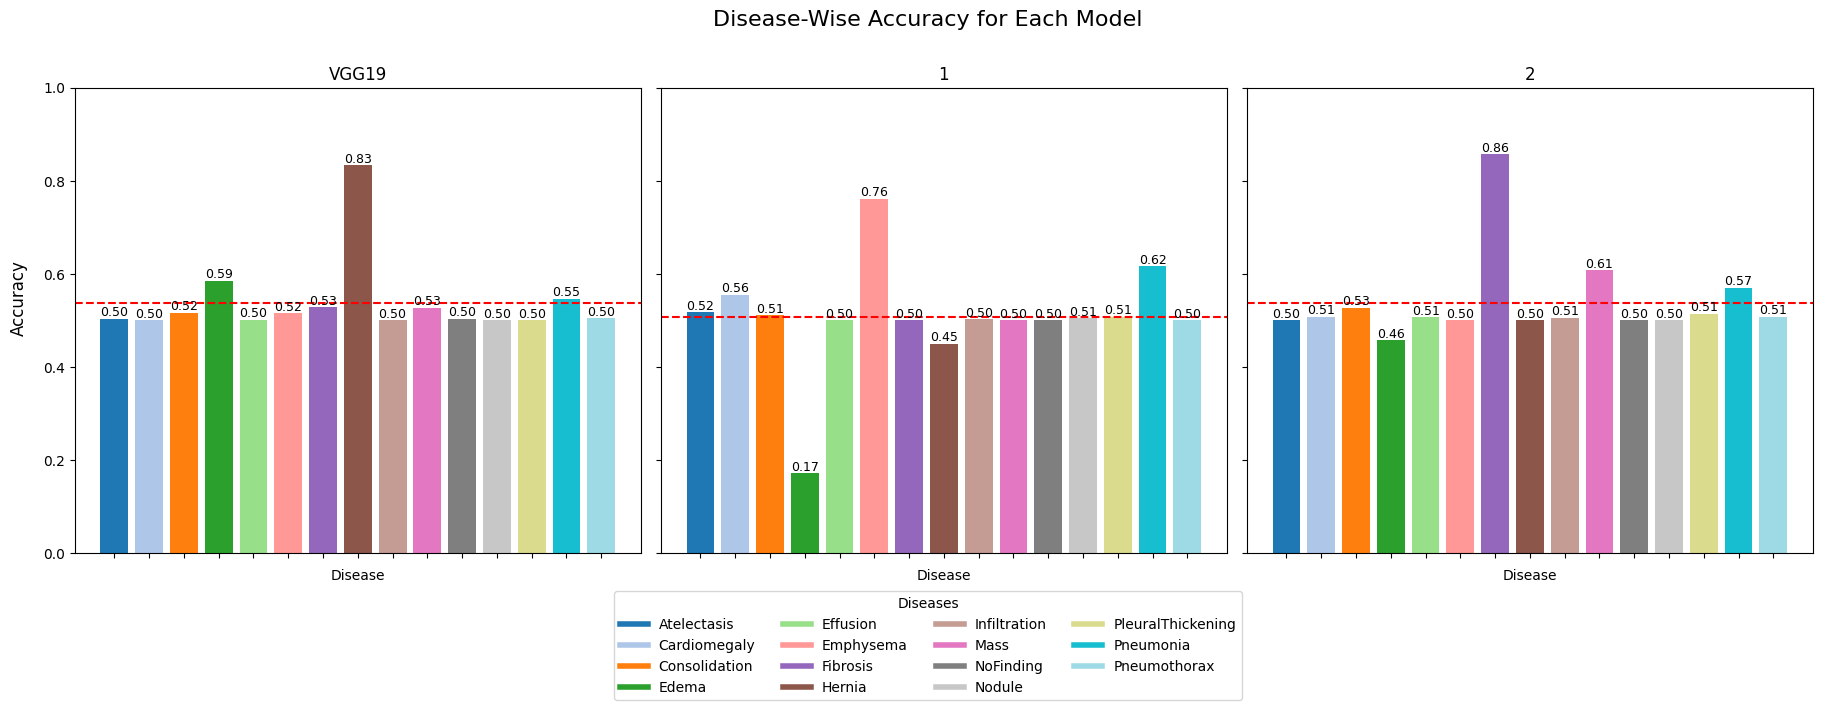

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace this with your actual dataset)
data = pd.DataFrame({
    'Model': ['VGG19', 'ResNet101', 'InceptionV3'],
    'Atelectasis': [0.5036, 0.5178, 0.5],
    'Cardiomegaly': [0.5, 0.5551, 0.5079],
    'Consolidation': [0.5166, 0.511, 0.5276],
    'Edema': [0.5857, 0.1714, 0.4571],
    'Effusion': [0.5017, 0.5, 0.5068],
    'Emphysema': [0.5154, 0.7615, 0.5],
    'Fibrosis': [0.5286, 0.5, 0.8571],
    'Hernia': [0.8333, 0.45, 0.5],
    'Infiltration': [0.5006, 0.5023, 0.5058],
    'Mass': [0.5268, 0.5, 0.6073],
    'NoFinding': [0.5039, 0.5, 0.5],
    'Nodule': [0.5, 0.505, 0.5],
    'PleuralThickening': [0.5, 0.5073, 0.5146],
    'Pneumonia': [0.5465, 0.6163, 0.5698],
    'Pneumothorax': [0.5049, 0.5, 0.5073],
})

# Extract disease names
disease_names = data.columns[1:]  # excluding 'Model'

# Number of models to display
num_models = len(data)

# Define the color map
color_map = plt.cm.tab20(np.linspace(0, 1, len(disease_names)))

# Create a grid of subplots (1 row x num_models columns)
fig, axes = plt.subplots(1, num_models, figsize=(18, 6), sharey=True)

# Loop through each model and plot the data
for i, (model_name, row) in enumerate(data.iterrows()):
    disease_accuracies = row[1:].values  # get accuracy values
    average_accuracy = disease_accuracies.mean()

    # Plot the bar chart for the current model
    bars = axes[i].bar(disease_names, disease_accuracies, color=color_map)

    # Add a horizontal line for average accuracy
    axes[i].axhline(y=average_accuracy, color='red', linestyle='--', label=f'Avg Accuracy: {average_accuracy:.2f}')
    
    if model_name == 0:
        model_name = "VGG19"

    # Set the title and labels
    axes[i].set_title(f'{model_name}', fontsize=12)
    axes[i].set_xlabel('Disease', fontsize=10)
    axes[i].set_ylim(0, 1)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    # Remove x-tick labels
    axes[i].set_xticklabels([])


# Set a common ylabel
fig.suptitle('Disease-Wise Accuracy for Each Model', fontsize=16)
fig.text(-0.01, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=12)

# Create the legend for disease colors
handles = [plt.Line2D([0], [0], color=color_map[i], lw=4) for i in range(len(disease_names))]
labels = disease_names
fig.legend(handles, labels, title="Diseases", loc='center', bbox_to_anchor=(0.5, -0.08), ncol=4)

# Display the grid of plots
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the suptitle
plt.show()

In [35]:
# Load the CSV data
df = pd.read_csv('/N/u/nothamil/BigRed200/triplet/627/Metrics/Output/combined.csv')

df.head

<bound method NDFrame.head of                 Model  Overall Accuracy  Accuracy for Atelectasis  \
0               VGG19          0.506487                    0.5036   
1           ResNet101          0.508362                    0.5178   
2   InceptionResNetV2          0.512781                    0.5036   
3            ResNet50          0.514680                    0.5018   
4         InceptionV3          0.513251                    0.5000   
5          ResNet50V2          0.507295                    0.5018   
6            xception          0.505754                    0.5053   
7         ResNet152V2          0.513455                    0.5107   
8           ResNet152          0.509121                    0.5018   
9              mobile          0.509004                    0.5018   
10        ResNet101V2          0.510409                    0.5071   

    Accuracy for Cardiomegaly  Accuracy for Consolidation  Accuracy for Edema  \
0                      0.5000                      0.5166   

# ResNet Models

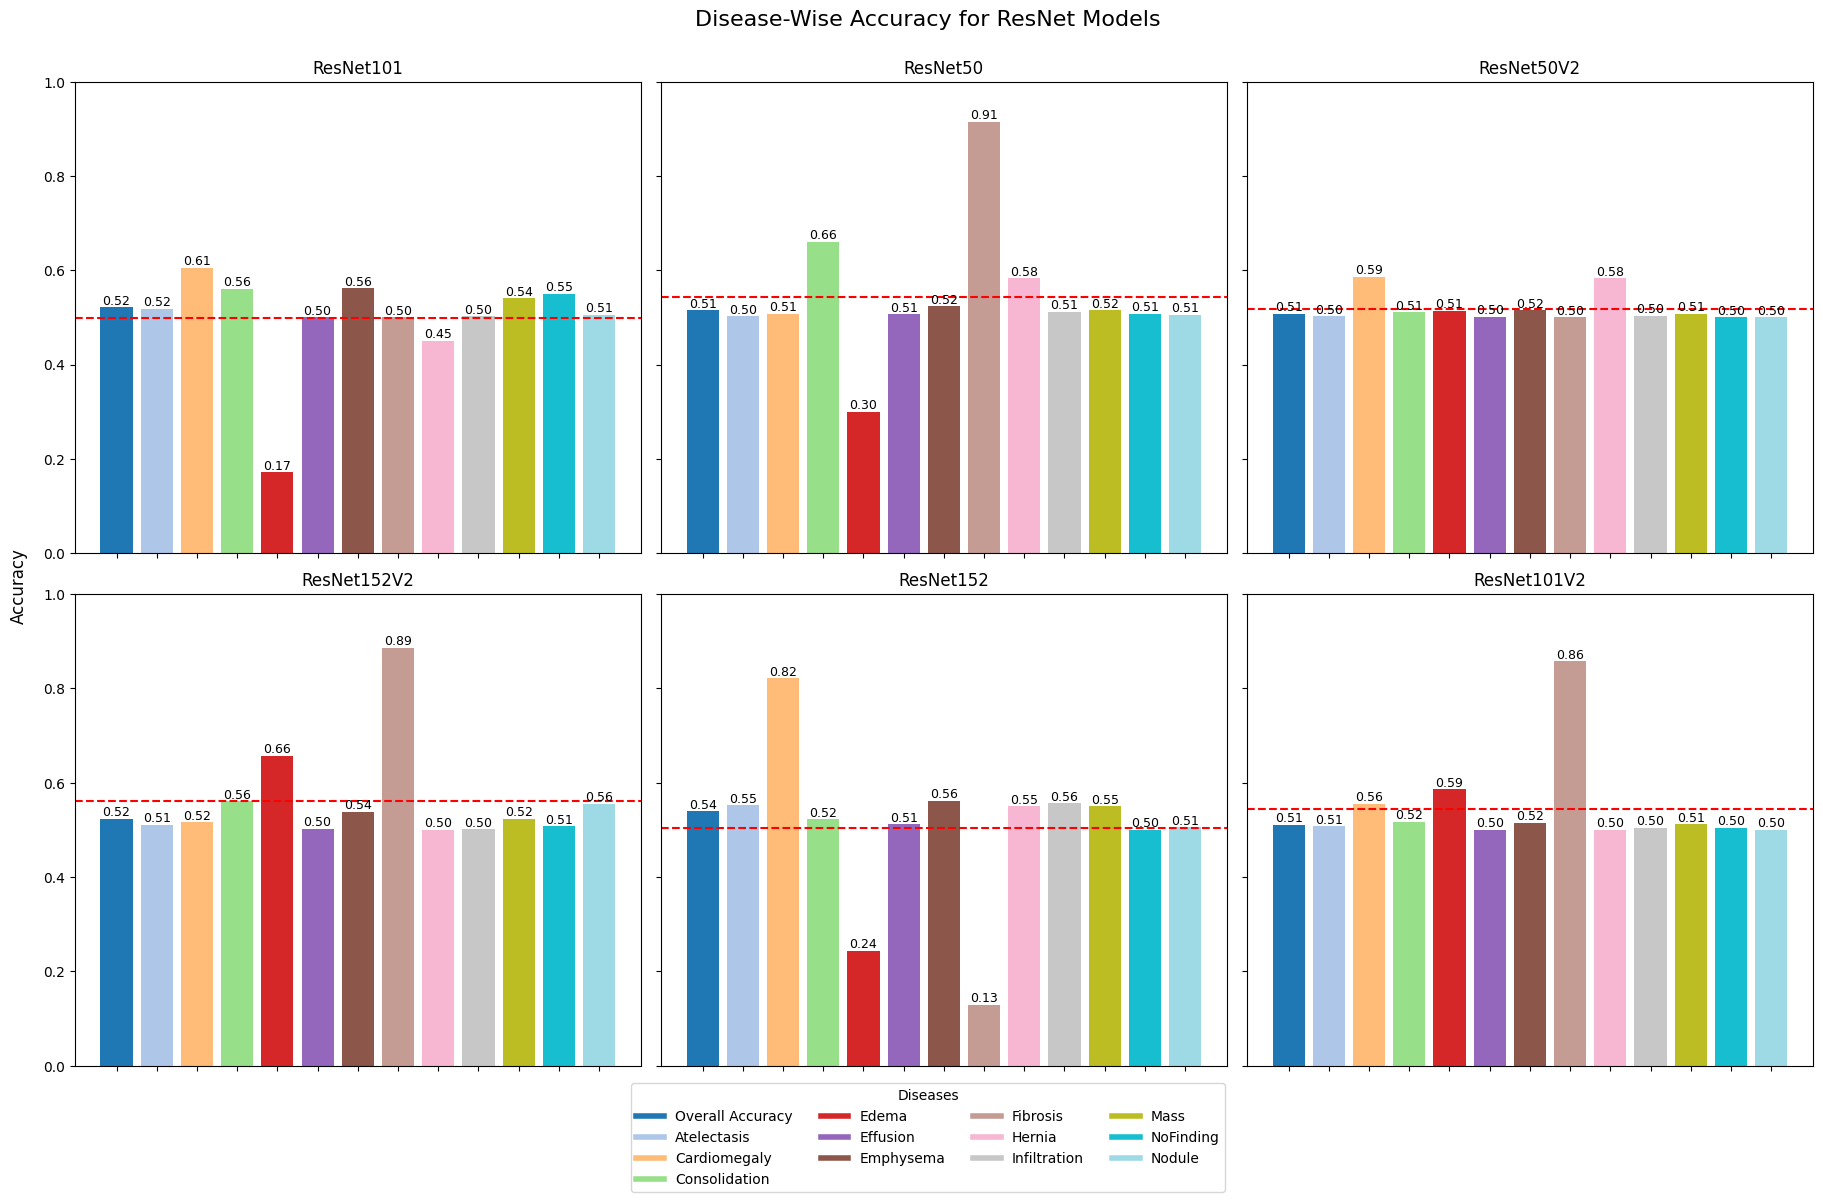

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV data
df = pd.read_csv('/N/u/nothamil/BigRed200/triplet/627/Metrics/Output/combined.csv')

# Extract disease names (ignoring the first two columns: 'Model' and 'Overall Accuracy')
disease_names = df.columns[1:-6].str.replace('Accuracy for ', '', regex=False)  # These columns represent disease accuracies

# Filter model names that contain 'ResNet'
model_names = df['Model']
resnet_models = model_names[model_names.str.contains('ResNet', case=False)]
resnet_models = resnet_models[resnet_models != 'InceptionResNetV2']  # Exclude 'InceptionResNetV2'

# Number of models to display
num_models = len(resnet_models)

# Define the 'tab20' colormap for distinct colors
color_map = plt.cm.tab20(np.linspace(0, 1, len(disease_names)))

# Create a grid of subplots (3 rows x 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each ResNet model and plot the data
for i, model_name in enumerate(resnet_models):
    # Get the corresponding row for the current model
    row = df[df['Model'] == model_name]
    
    # Extract disease accuracies for the current model
    disease_accuracies = row.iloc[0, 1:-6].values  # Get accuracy values for each disease
    average_accuracy = disease_accuracies.mean()

    # Plot the bar chart for the current model
    bars = axes[i].bar(disease_names, disease_accuracies, color=color_map)

    # Add a horizontal line for average accuracy
    axes[i].axhline(y=average_accuracy, color='red', linestyle='--', label=f'Avg Accuracy: {average_accuracy:.2f}')
    
    # Set the title and labels
    axes[i].set_title(f'{model_name}', fontsize=12)
    axes[i].set_ylim(0, 1)
    
    # Remove x-tick labels
    axes[i].set_xticklabels([])

    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Adjust layout to prevent overlap
fig.suptitle('Disease-Wise Accuracy for ResNet Models', fontsize=16)

# Move the y-axis label outside the plot area
fig.text(-0.01, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=12)

# Adjust the legend position to avoid overlap with the subplots
handles = [plt.Line2D([0], [0], color=color_map[i], lw=4) for i in range(len(disease_names))]
labels = disease_names
fig.legend(handles, labels, title="Diseases", loc='center', bbox_to_anchor=(0.5, 0.04), ncol=4)

# Adjust subplot spacing to avoid clipping
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.1)  # Adjust 'top' for title, 'bottom' for legend

# Display the grid of plots
plt.show()

# Inception Models

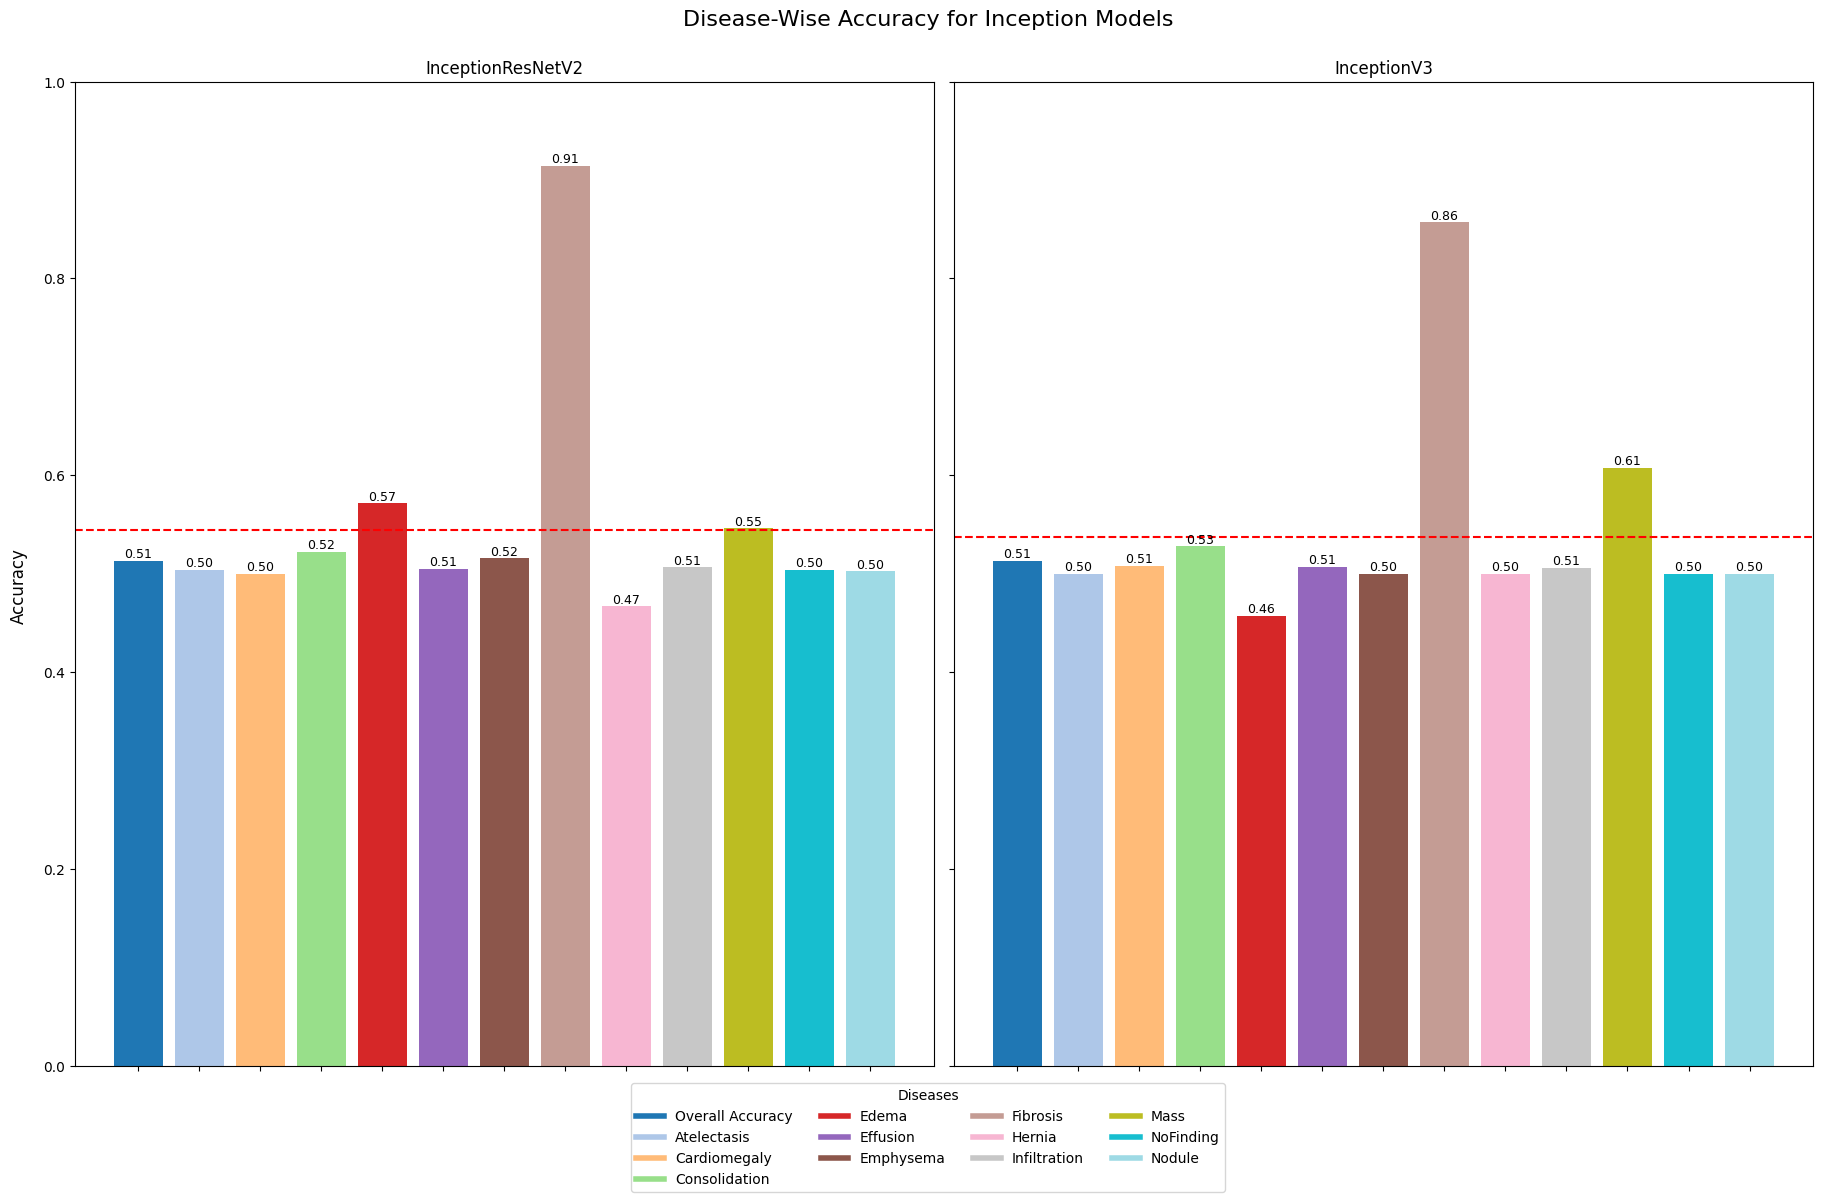

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV data
df = pd.read_csv('/N/u/nothamil/BigRed200/triplet/627/Metrics/Output/combined.csv')

# Extract disease names (ignoring the first two columns: 'Model' and 'Overall Accuracy')
disease_names = df.columns[1:-6].str.replace('Accuracy for ', '', regex=False)  # These columns represent disease accuracies

# Filter model names that contain 'ResNet'
model_names = df['Model']
resnet_models = model_names[model_names.str.contains('Inception', case=False)]

# Number of models to display
num_models = len(resnet_models)

# Define the 'tab20' colormap for distinct colors
color_map = plt.cm.tab20(np.linspace(0, 1, len(disease_names)))

# Create a grid of subplots (3 rows x 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 12), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each ResNet model and plot the data
for i, model_name in enumerate(resnet_models):
    # Get the corresponding row for the current model
    row = df[df['Model'] == model_name]
    
    # Extract disease accuracies for the current model
    disease_accuracies = row.iloc[0, 1:-6].values  # Get accuracy values for each disease
    average_accuracy = disease_accuracies.mean()

    # Plot the bar chart for the current model
    bars = axes[i].bar(disease_names, disease_accuracies, color=color_map)

    # Add a horizontal line for average accuracy
    axes[i].axhline(y=average_accuracy, color='red', linestyle='--', label=f'Avg Accuracy: {average_accuracy:.2f}')
    
    # Set the title and labels
    axes[i].set_title(f'{model_name}', fontsize=12)
    axes[i].set_ylim(0, 1)
    
    # Remove x-tick labels
    axes[i].set_xticklabels([])

    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Adjust layout to prevent overlap
fig.suptitle('Disease-Wise Accuracy for Inception Models', fontsize=16)

# Move the y-axis label outside the plot area
fig.text(-0.01, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=12)

# Adjust the legend position to avoid overlap with the subplots
handles = [plt.Line2D([0], [0], color=color_map[i], lw=4) for i in range(len(disease_names))]
labels = disease_names
fig.legend(handles, labels, title="Diseases", loc='center', bbox_to_anchor=(0.5, 0.04), ncol=4)

# Adjust subplot spacing to avoid clipping
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.1)  # Adjust 'top' for title, 'bottom' for legend

# Display the grid of plots
plt.show()

# Other Models

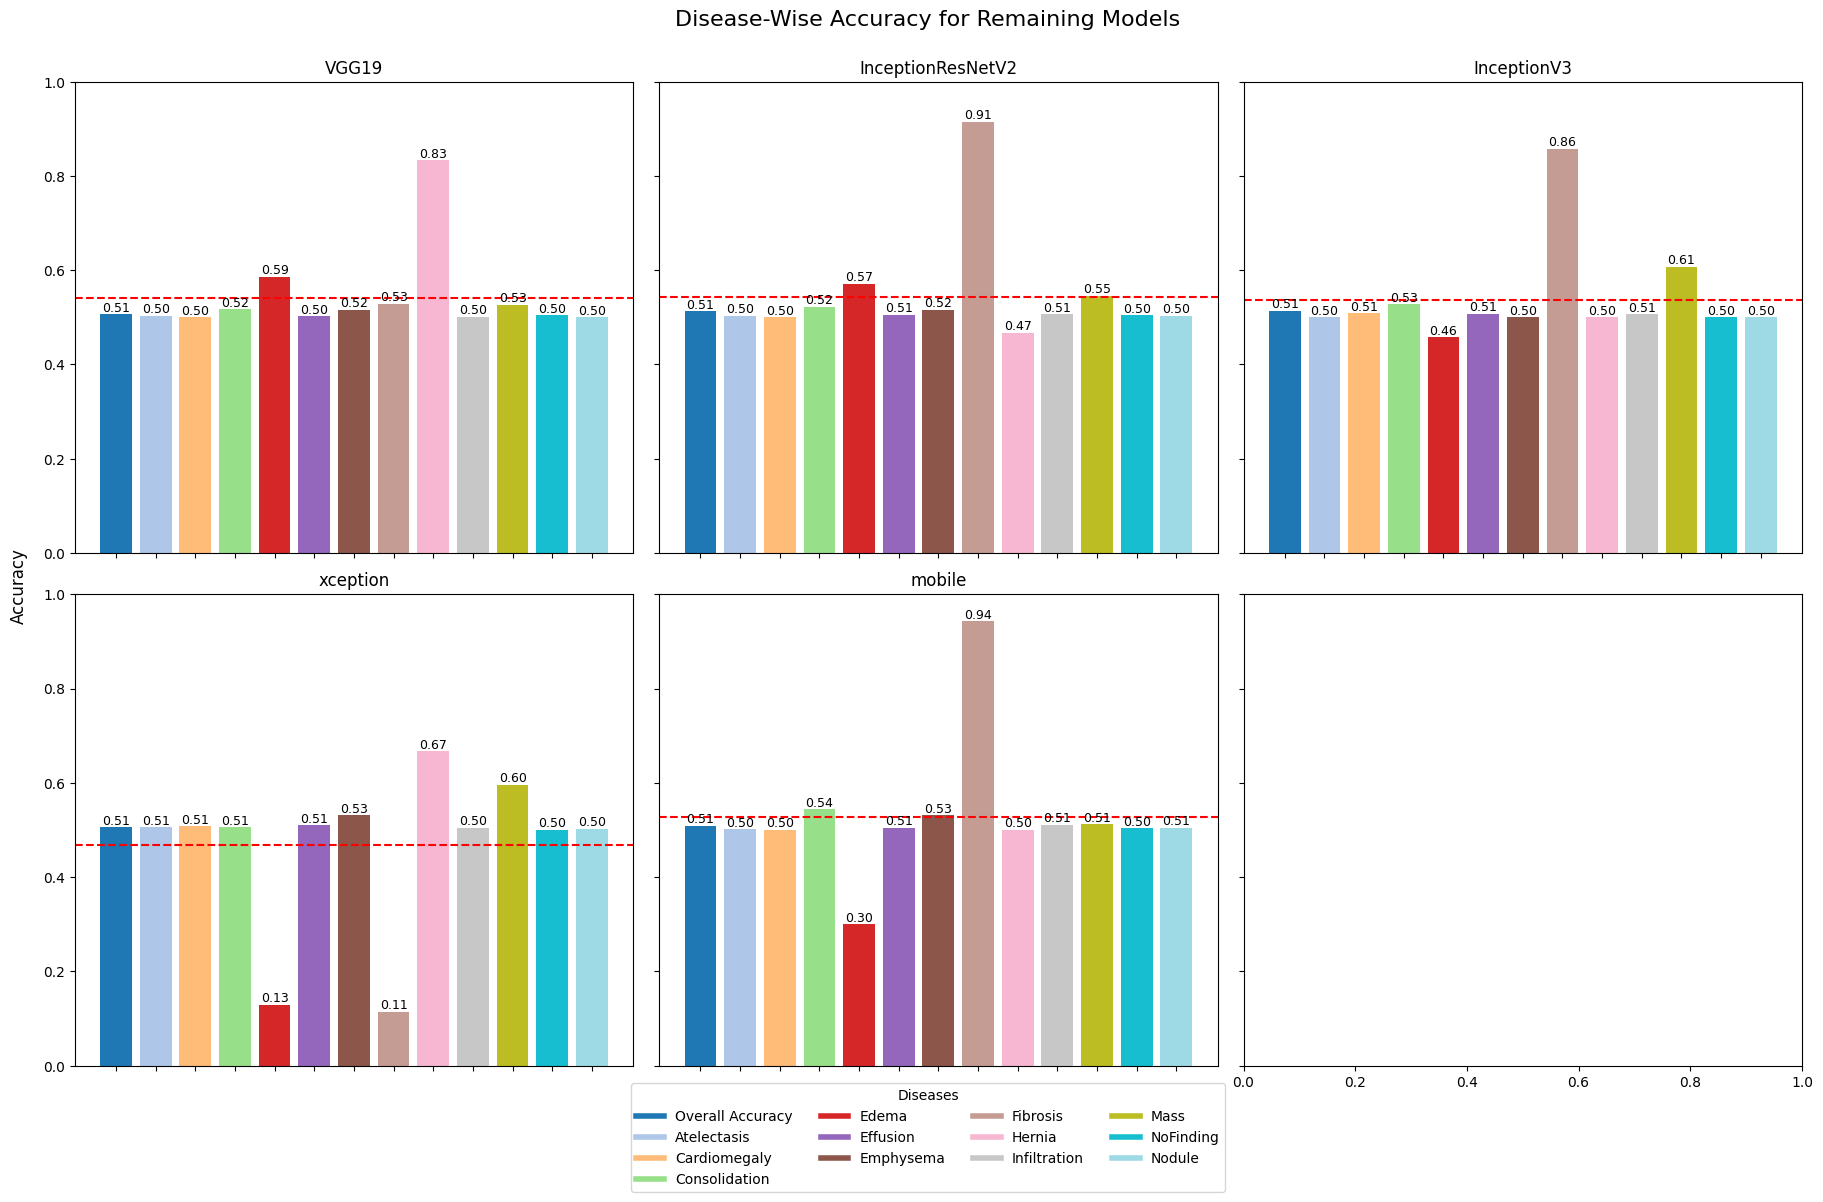

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV data
df = pd.read_csv('/N/u/nothamil/BigRed200/triplet/627/Metrics/Output/combined.csv')

# Extract disease names (ignoring the first two columns: 'Model' and 'Overall Accuracy')
disease_names = df.columns[1:-6].str.replace('Accuracy for ', '', regex=False)  # These columns represent disease accuracies

# Filter model names that contain 'ResNet'
model_names = df['Model']
#resnet_models = model_names[~model_names.str.contains('Inception', case=False)]
resnet_models = model_names[~model_names.str.contains('ResNet1', case=False)]
resnet_models = resnet_models[~resnet_models.str.contains('ResNet5', case=False)]

# Number of models to display
num_models = len(resnet_models)

# Define the 'tab20' colormap for distinct colors
color_map = plt.cm.tab20(np.linspace(0, 1, len(disease_names)))

# Create a grid of subplots (3 rows x 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each ResNet model and plot the data
for i, model_name in enumerate(resnet_models):
    # Get the corresponding row for the current model
    row = df[df['Model'] == model_name]
    
    # Extract disease accuracies for the current model
    disease_accuracies = row.iloc[0, 1:-6].values  # Get accuracy values for each disease
    average_accuracy = disease_accuracies.mean()

    # Plot the bar chart for the current model
    bars = axes[i].bar(disease_names, disease_accuracies, color=color_map)

    # Add a horizontal line for average accuracy
    axes[i].axhline(y=average_accuracy, color='red', linestyle='--', label=f'Avg Accuracy: {average_accuracy:.2f}')
    
    # Set the title and labels
    axes[i].set_title(f'{model_name}', fontsize=12)
    axes[i].set_ylim(0, 1)
    
    # Remove x-tick labels
    axes[i].set_xticklabels([])

    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Adjust layout to prevent overlap
fig.suptitle('Disease-Wise Accuracy for Remaining Models', fontsize=16)

# Move the y-axis label outside the plot area
fig.text(-0.01, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=12)

# Adjust the legend position to avoid overlap with the subplots
handles = [plt.Line2D([0], [0], color=color_map[i], lw=4) for i in range(len(disease_names))]
labels = disease_names
fig.legend(handles, labels, title="Diseases", loc='center', bbox_to_anchor=(0.5, 0.04), ncol=4)

# Adjust subplot spacing to avoid clipping
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.1)  # Adjust 'top' for title, 'bottom' for legend

# Display the grid of plots
plt.show()

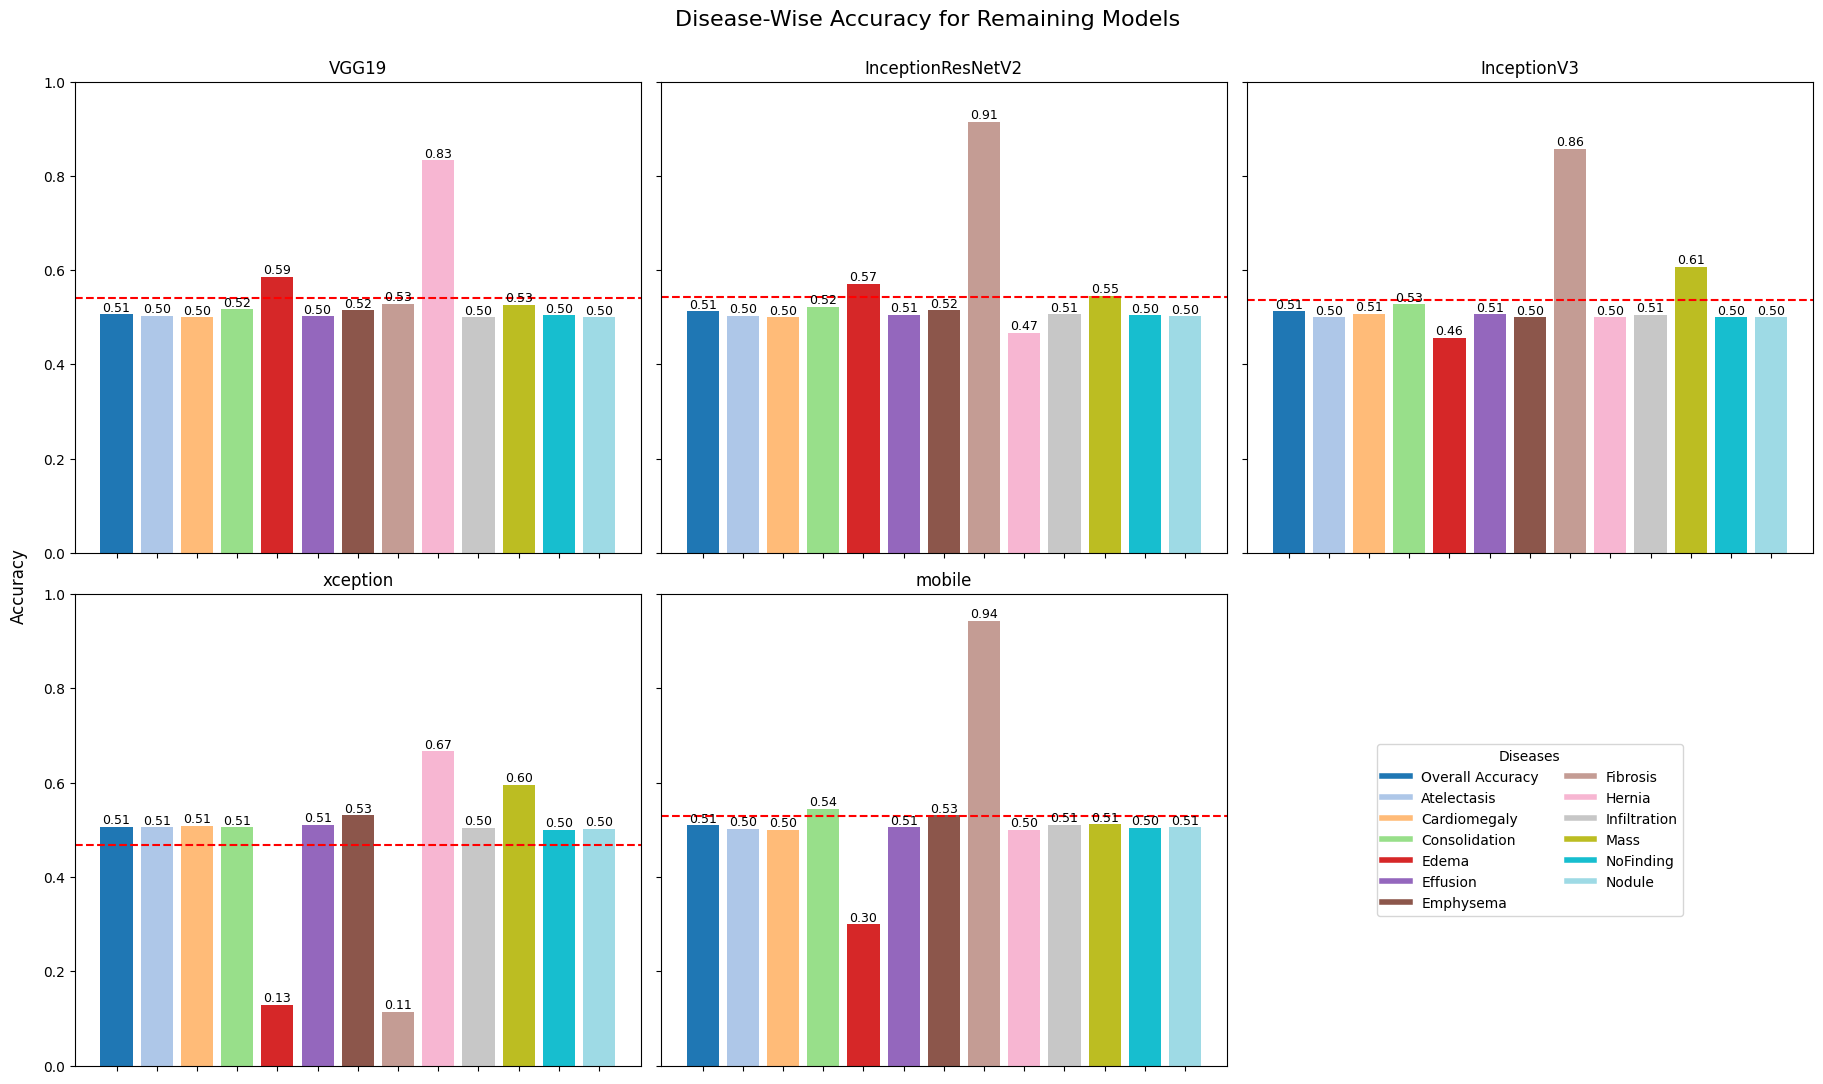

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV data
df = pd.read_csv('/N/u/nothamil/BigRed200/triplet/627/Metrics/Output/combined.csv')

# Extract disease names (ignoring the first two columns: 'Model' and 'Overall Accuracy')
disease_names = df.columns[1:-6].str.replace('Accuracy for ', '', regex=False)  # These columns represent disease accuracies

# Filter model names that contain 'ResNet'
model_names = df['Model']
resnet_models = model_names[~model_names.str.contains('ResNet1', case=False)]
resnet_models = resnet_models[~resnet_models.str.contains('ResNet5', case=False)]

# Number of models to display
num_models = len(resnet_models)

# Define the 'tab20' colormap for distinct colors
color_map = plt.cm.tab20(np.linspace(0, 1, len(disease_names)))

# Create a grid of subplots (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each ResNet model and plot the data
for i, model_name in enumerate(resnet_models):
    # Get the corresponding row for the current model
    row = df[df['Model'] == model_name]
    
    # Extract disease accuracies for the current model
    disease_accuracies = row.iloc[0, 1:-6].values  # Get accuracy values for each disease
    average_accuracy = disease_accuracies.mean()

    # Plot the bar chart for the current model
    bars = axes[i].bar(disease_names, disease_accuracies, color=color_map)

    # Add a horizontal line for average accuracy
    axes[i].axhline(y=average_accuracy, color='red', linestyle='--', label=f'Avg Accuracy: {average_accuracy:.2f}')
    
    # Set the title and labels
    axes[i].set_title(f'{model_name}', fontsize=12)
    axes[i].set_ylim(0, 1)
    
    # Remove x-tick labels
    axes[i].set_xticklabels([])

    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Hide the empty plot (last subplot)
axes[-1].axis('off')

# Place the legend in the empty plot's position
handles = [plt.Line2D([0], [0], color=color_map[i], lw=4) for i in range(len(disease_names))]
labels = disease_names
axes[-1].legend(handles, labels, title="Diseases", loc='center', bbox_to_anchor=(0.5, 0.5), ncol=2)

# Adjust layout to prevent overlap
fig.suptitle('Disease-Wise Accuracy for Remaining Models', fontsize=16)

# Move the y-axis label outside the plot area
fig.text(-0.01, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=12)

# Adjust subplot spacing to avoid clipping
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.1)  # Adjust 'top' for title, 'bottom' for legend

# Display the grid of plots
plt.show()

# Overall Accuracy

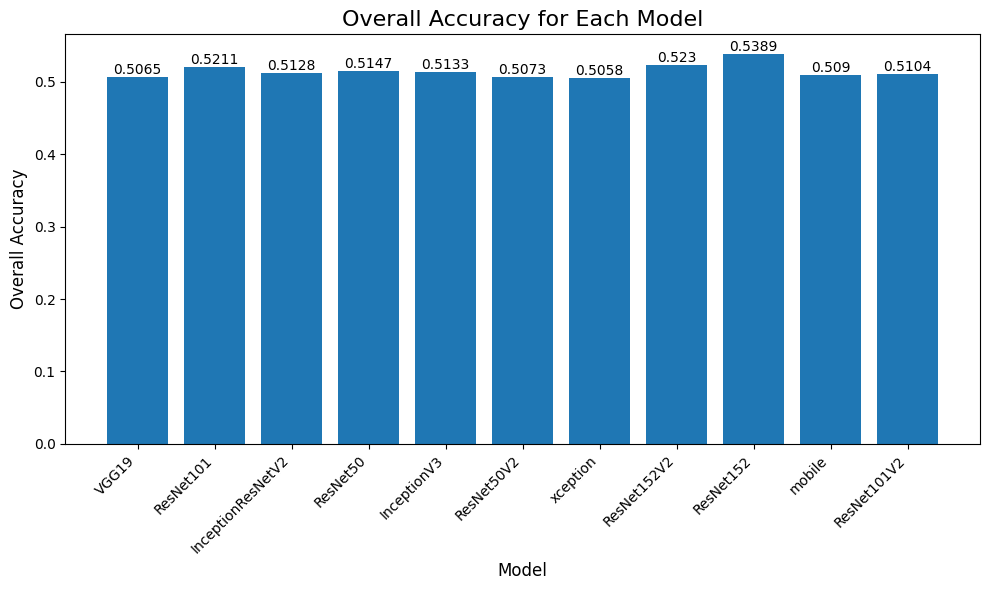

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV data
df = pd.read_csv('/N/u/nothamil/BigRed200/triplet/627/Metrics/Output/combined.csv')

# Extract model names (excluding those containing "Inception")
model_names = df['Model']

# Extract overall accuracy values
overall_accuracies = df['Overall Accuracy']

# Filter the DataFrame to include only the models we want
df_filtered = df[df['Model'].isin(model_names)]

# Number of models to display
num_models = len(model_names)

# Define a distinct color for each model
color_map = plt.cm.tab20(np.linspace(0, 1, num_models))

# Create the bar chart for overall accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(df_filtered['Model'], df_filtered['Overall Accuracy'])

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 4)}', ha='center', va='bottom', fontsize=10)

# Set title and labels
plt.title('Overall Accuracy for Each Model', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Overall Accuracy', fontsize=12)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')

# Adjust layout for better visibility
plt.tight_layout()

# Display the plot
plt.show()

In [76]:
input_text = """Epoch 1/50
1443/1443 - 1809s - loss: 0.4702 - val_loss: 0.4925 - 1809s/epoch - 1s/step
Epoch 2/50
1443/1443 - 345s - loss: 0.4534 - val_loss: 0.4920 - 345s/epoch - 239ms/step
Epoch 3/50
1443/1443 - 344s - loss: 0.4486 - val_loss: 0.4899 - 344s/epoch - 239ms/step
Epoch 4/50
1443/1443 - 344s - loss: 0.4469 - val_loss: 0.4774 - 344s/epoch - 239ms/step
Epoch 5/50
1443/1443 - 345s - loss: 0.4453 - val_loss: 0.4732 - 345s/epoch - 239ms/step
Epoch 6/50
1443/1443 - 345s - loss: 0.4413 - val_loss: 0.4625 - 345s/epoch - 239ms/step
Epoch 7/50
1443/1443 - 345s - loss: 0.4385 - val_loss: 0.4303 - 345s/epoch - 239ms/step
Epoch 8/50
1443/1443 - 345s - loss: 0.4359 - val_loss: 0.4443 - 345s/epoch - 239ms/step
Epoch 9/50
1443/1443 - 344s - loss: 0.4343 - val_loss: 0.4390 - 344s/epoch - 239ms/step
Epoch 10/50
1443/1443 - 345s - loss: 0.4333 - val_loss: 0.4539 - 345s/epoch - 239ms/step
Epoch 11/50
1443/1443 - 345s - loss: 0.4321 - val_loss: 0.4423 - 345s/epoch - 239ms/step
Epoch 12/50
1443/1443 - 347s - loss: 0.4312 - val_loss: 0.4295 - 347s/epoch - 240ms/step
Epoch 13/50
1443/1443 - 348s - loss: 0.4308 - val_loss: 0.4230 - 348s/epoch - 241ms/step
Epoch 14/50
1443/1443 - 346s - loss: 0.4299 - val_loss: 0.4131 - 346s/epoch - 240ms/step
Epoch 15/50
1443/1443 - 348s - loss: 0.4286 - val_loss: 0.4339 - 348s/epoch - 241ms/step
Epoch 16/50
1443/1443 - 348s - loss: 0.4283 - val_loss: 0.4219 - 348s/epoch - 241ms/step
Epoch 17/50
1443/1443 - 348s - loss: 0.4285 - val_loss: 0.4442 - 348s/epoch - 241ms/step
Epoch 18/50
1443/1443 - 348s - loss: 0.4283 - val_loss: 0.4350 - 348s/epoch - 241ms/step
Epoch 19/50
1443/1443 - 348s - loss: 0.4275 - val_loss: 0.4406 - 348s/epoch - 241ms/step
Epoch 20/50
1443/1443 - 347s - loss: 0.4269 - val_loss: 0.4164 - 347s/epoch - 240ms/step
Epoch 21/50
1443/1443 - 348s - loss: 0.4269 - val_loss: 0.4187 - 348s/epoch - 241ms/step
Epoch 22/50
1443/1443 - 348s - loss: 0.4256 - val_loss: 0.4322 - 348s/epoch - 241ms/step
Epoch 23/50
1443/1443 - 348s - loss: 0.4244 - val_loss: 0.4161 - 348s/epoch - 241ms/step
Epoch 24/50
1443/1443 - 348s - loss: 0.4245 - val_loss: 0.4230 - 348s/epoch - 241ms/step"""

In [77]:
import re

def use_regex(input_text):
    pattern = re.compile(r"1443/1443 - 1809s - loss: [0-9]*\.[0-9]+ - val_loss: [0-9]*\.[0-9]+ - 1809s/epoch - 1s/step", re.IGNORECASE)
    return pattern.match(input_text)

In [79]:
print(use_regex(input_text))

None
